In [5]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

!pip install optuna
!pip install timm
!pip install scikit-learn
!pip install pandas
!pip install seaborn

torch version: 1.13.1
torchvision version: 0.14.1
time: 7.89 s (started: 2023-05-08 14:12:09 +00:00)


In [6]:
# Continue with regular imports
!pip install matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.11 s (started: 2023-05-08 14:12:17 +00:00)


In [4]:
#unzip the data that we had split earlier before in the preprocessing notebook, to ensure that the same arrangement of data 
#is used for every model. 
!unzip /isic2019-dataset.zip

Archive:  /isic2019-dataset.zip
  inflating: data/ISIC2019.zip       
  inflating: data/test/AK/ISIC_0024468.jpg  
  inflating: data/test/AK/ISIC_0026040.jpg  
  inflating: data/test/AK/ISIC_0026171.jpg  
  inflating: data/test/AK/ISIC_0026626.jpg  
  inflating: data/test/AK/ISIC_0027447.jpg  
  inflating: data/test/AK/ISIC_0029141.jpg  
  inflating: data/test/AK/ISIC_0029915.jpg  
  inflating: data/test/AK/ISIC_0031506.jpg  
  inflating: data/test/AK/ISIC_0031993.jpg  
  inflating: data/test/AK/ISIC_0033358.jpg  
  inflating: data/test/AK/ISIC_0033494.jpg  
  inflating: data/test/AK/ISIC_0053749.jpg  
  inflating: data/test/AK/ISIC_0053879.jpg  
  inflating: data/test/AK/ISIC_0053944.jpg  
  inflating: data/test/AK/ISIC_0053950.jpg  
  inflating: data/test/AK/ISIC_0054081.jpg  
  inflating: data/test/AK/ISIC_0054259.jpg  
  inflating: data/test/AK/ISIC_0054271.jpg  
  inflating: data/test/AK/ISIC_0054433.jpg  
  inflating: data/test/AK/ISIC_0054805.jpg  
  inflating: data/test/AK/ISIC

In [3]:
from torchvision.transforms import Compose, CenterCrop, Normalize, Resize, ToTensor
from torchvision.transforms import InterpolationMode
from torchvision.transforms import RandAugment

# Set the random seed for reproducibility
torch.manual_seed(42)

# Define the transformation parameters
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


time: 2.89 ms (started: 2023-05-07 17:52:35 +00:00)


In [4]:
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import optuna
import timm
import torch.utils.data.sampler as sampler
from torch.utils.data import Subset
from torch.utils.data.sampler import RandomSampler
import torchvision.datasets as datasets
from sklearn import metrics
from sklearn.metrics import f1_score

# Set the random seed for reproducibility
torch.manual_seed(42)

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

#define hyperparameter tuning, furthermore we will use 
#10 trials to look for the best hyperparameters. We re-used the optuna hyperparamete optimization code 

# Define the dataset and dataloader
def get_data_loaders(batch_size):

# Load and transform the data

    # Load the datasets
    train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
    val_dataset = datasets.ImageFolder(root='data/valid', transform=transform)

    # load the data and shuffle the training data
    train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
    valid_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

    return train_dataloader, valid_dataloader

def get_model(trial, dropout, num_hidden_layers, num_neurons):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_name = 'mvitv2_large'
    model = timm.create_model(model_name, pretrained=True, num_classes=8)
    
    num_in_features = model.get_classifier().in_features

    # Define the classification head with the number of neurons and hidden layers to optimize
    classifier_layers = []
    for i in range(num_hidden_layers):
        if i == 0:
            in_features = num_in_features
            out_features = num_neurons
        else:
            in_features = num_neurons
            out_features = num_neurons
        classifier_layers.extend([
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.Dropout(p=dropout),
        ])
    classifier_layers.append(nn.Linear(num_neurons, 8))
    model.head.fc = nn.Sequential(*classifier_layers)

    # Freeze the weights
    for param in model.parameters():
        param.requires_grad = False
   
    # Unfreeze the classifierhead layer 
    for param in model.head.parameters():
        param.requires_grad = True

    return model

# Define the objective function for Optuna
def objective(trial):
    # Get the hyperparameters to optimize
    batch_size = 32  # set batch size to 32
    epochs = 20  # set epochs to 20
    num_epochs = 20
    optimizer_name = trial.suggest_categorical("optimizer_name", ["AdamW", "SGD"])
    weight_decay = trial.suggest_float("weight_decay", low=0.001, high=0.01, log=True)
    learning_rate = trial.suggest_float("learning_rate", low=0.001, high=0.01, log=True)
    dropout = trial.suggest_categorical("dropout", [0.25,0.5])
    num_hidden_layers = trial.suggest_int("num_hidden_layers", low=1, high=2)
    num_neurons = trial.suggest_categorical("num_neurons", [256, 512])

    # Get the data loaders
    train_dataloader, valid_dataloader = get_data_loaders(batch_size)

    # Get the model
    model = get_model(trial, dropout, num_hidden_layers, num_neurons)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Define the optimizer and loss function
    if optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

# Initialize variables for early stopping
    best_accuracy = 0.0
    best_val_loss = float('inf')
    best_f1_score = 0.0
    patience = 3
    no_improvement_count = 0

   # Train the model
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        running_total = 0
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                scaler.scale(loss).backward()    # Scale the gradients
                scaler.step(optimizer)           # Update the model parameters
                scaler.update()                  # Update the scaler

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_corrects += (predicted == labels).sum().item()

        # Calculate the training loss and training accuracy
        train_loss = running_loss / len(train_dataloader.dataset)
        train_accuracy = 100 * running_corrects / running_total

        # evaluate on the validation set
        correct = 0
        total = 0
        val_loss = 0.0
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for data in valid_dataloader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item() * labels.size(0)

                y_true += labels.cpu().tolist()
                y_pred += predicted.cpu().tolist()

        # Calculate the validation accuracy and validation loss
        accuracy = 100 * correct / total
        val_loss /= len(valid_dataloader.dataset)

        #calculate the macro f1-score
        f1_score = metrics.f1_score(y_true, y_pred, average='macro')

        # Print the accuracy, validation loss, and f1-score
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, Validation Loss = {val_loss:.4f}, Validation Accuracy = {accuracy:.2f}%, F1-score = {f1_score:.4f}")

        # Report the intermediate result
        trial.report(f1_score, epoch)

        # Check if the validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Check if the f1 score has improved
        if f1_score > best_f1_score:
            best_f1_score = f1_score

        # Check if early stopping criteria has been met
        if no_improvement_count >= patience:
            print(f"No improvement after {no_improvement_count} epochs. Stopping training...")
            break

    return best_f1_score

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-05-07 17:52:36,607] A new study created in memory with name: no-name-11be038c-1804-4d4b-b463-53018a4d875d
Downloading: "https://dl.fbaipublicfiles.com/mvit/mvitv2_models/MViTv2_L_in1k.pyth" to /root/.cache/torch/hub/checkpoints/MViTv2_L_in1k.pyth


Epoch 1: Train Loss = 1.1405, Train Accuracy = 62.64%, Validation Loss = 0.9809, Validation Accuracy = 66.14%, F1-score = 0.3474
Epoch 2: Train Loss = 0.8679, Train Accuracy = 68.88%, Validation Loss = 0.8436, Validation Accuracy = 69.13%, F1-score = 0.3909
Epoch 3: Train Loss = 0.8087, Train Accuracy = 70.95%, Validation Loss = 0.8590, Validation Accuracy = 67.75%, F1-score = 0.4726
Epoch 4: Train Loss = 0.7874, Train Accuracy = 71.70%, Validation Loss = 0.8147, Validation Accuracy = 71.33%, F1-score = 0.4992
Epoch 5: Train Loss = 0.7730, Train Accuracy = 71.99%, Validation Loss = 0.8345, Validation Accuracy = 68.62%, F1-score = 0.4957
Epoch 6: Train Loss = 0.7450, Train Accuracy = 72.95%, Validation Loss = 0.7687, Validation Accuracy = 71.48%, F1-score = 0.5235
Epoch 7: Train Loss = 0.7259, Train Accuracy = 73.85%, Validation Loss = 0.7879, Validation Accuracy = 71.29%, F1-score = 0.4869
Epoch 8: Train Loss = 0.7134, Train Accuracy = 74.06%, Validation Loss = 0.8192, Validation Accur

[I 2023-05-07 18:06:47,702] Trial 0 finished with value: 0.547510114237133 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0010222166719202471, 'learning_rate': 0.0010548616550979672, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 512}. Best is trial 0 with value: 0.547510114237133.


Epoch 9: Train Loss = 0.6976, Train Accuracy = 74.32%, Validation Loss = 0.7855, Validation Accuracy = 72.47%, F1-score = 0.5475
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.1078, Train Accuracy = 63.93%, Validation Loss = 0.8932, Validation Accuracy = 68.26%, F1-score = 0.3786
Epoch 2: Train Loss = 0.8380, Train Accuracy = 69.90%, Validation Loss = 0.8265, Validation Accuracy = 69.60%, F1-score = 0.4143
Epoch 3: Train Loss = 0.7904, Train Accuracy = 71.45%, Validation Loss = 0.7992, Validation Accuracy = 70.19%, F1-score = 0.4319
Epoch 4: Train Loss = 0.7618, Train Accuracy = 72.39%, Validation Loss = 0.7964, Validation Accuracy = 70.23%, F1-score = 0.4751
Epoch 5: Train Loss = 0.7431, Train Accuracy = 73.30%, Validation Loss = 0.7956, Validation Accuracy = 69.84%, F1-score = 0.4569
Epoch 6: Train Loss = 0.7297, Train Accuracy = 73.54%, Validation Loss = 0.7855, Validation Accuracy = 71.25%, F1-score = 0.4761
Epoch 7: Train Loss = 0.7195, Train Accuracy 

[I 2023-05-07 18:23:55,641] Trial 1 finished with value: 0.525178324538651 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.004304165368693326, 'learning_rate': 0.0030456663813804036, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 0 with value: 0.547510114237133.


Epoch 12: Train Loss = 0.7002, Train Accuracy = 74.62%, Validation Loss = 0.7834, Validation Accuracy = 70.97%, F1-score = 0.4880
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2326, Train Accuracy = 61.55%, Validation Loss = 0.9460, Validation Accuracy = 69.32%, F1-score = 0.3861
Epoch 2: Train Loss = 0.8418, Train Accuracy = 69.86%, Validation Loss = 0.8241, Validation Accuracy = 69.84%, F1-score = 0.4385
Epoch 3: Train Loss = 0.7805, Train Accuracy = 71.93%, Validation Loss = 0.7966, Validation Accuracy = 70.54%, F1-score = 0.4348
Epoch 4: Train Loss = 0.7552, Train Accuracy = 72.66%, Validation Loss = 0.7977, Validation Accuracy = 70.62%, F1-score = 0.4921
Epoch 5: Train Loss = 0.7301, Train Accuracy = 73.57%, Validation Loss = 0.8460, Validation Accuracy = 68.11%, F1-score = 0.4489
Epoch 6: Train Loss = 0.7135, Train Accuracy = 74.02%, Validation Loss = 0.7688, Validation Accuracy = 71.80%, F1-score = 0.5178
Epoch 7: Train Loss = 0.6979, Train Accuracy

[I 2023-05-07 18:41:01,662] Trial 2 finished with value: 0.569865462628275 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0011134538710744885, 'learning_rate': 0.00138168185311329, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 2 with value: 0.569865462628275.


Epoch 12: Train Loss = 0.6531, Train Accuracy = 76.34%, Validation Loss = 0.7763, Validation Accuracy = 71.52%, F1-score = 0.5477
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.1934, Train Accuracy = 61.06%, Validation Loss = 0.8896, Validation Accuracy = 67.56%, F1-score = 0.3899
Epoch 2: Train Loss = 0.8681, Train Accuracy = 68.43%, Validation Loss = 0.8564, Validation Accuracy = 67.87%, F1-score = 0.3925
Epoch 3: Train Loss = 0.8224, Train Accuracy = 70.26%, Validation Loss = 0.8566, Validation Accuracy = 68.62%, F1-score = 0.4481
Epoch 4: Train Loss = 0.7904, Train Accuracy = 71.26%, Validation Loss = 0.8573, Validation Accuracy = 68.85%, F1-score = 0.4973
Epoch 5: Train Loss = 0.7764, Train Accuracy = 71.65%, Validation Loss = 0.8504, Validation Accuracy = 70.23%, F1-score = 0.4548
Epoch 6: Train Loss = 0.7627, Train Accuracy = 72.30%, Validation Loss = 0.8046, Validation Accuracy = 70.62%, F1-score = 0.4412
Epoch 7: Train Loss = 0.7455, Train Accuracy

[I 2023-05-07 18:58:09,221] Trial 3 finished with value: 0.5399125898336421 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0011770314630399374, 'learning_rate': 0.009114491669688524, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 2 with value: 0.569865462628275.


Epoch 12: Train Loss = 0.6988, Train Accuracy = 74.65%, Validation Loss = 0.8187, Validation Accuracy = 72.00%, F1-score = 0.4847
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.1792, Train Accuracy = 62.07%, Validation Loss = 0.9669, Validation Accuracy = 67.67%, F1-score = 0.3820
Epoch 2: Train Loss = 0.8530, Train Accuracy = 69.27%, Validation Loss = 0.8441, Validation Accuracy = 68.93%, F1-score = 0.4186
Epoch 3: Train Loss = 0.7891, Train Accuracy = 71.41%, Validation Loss = 0.8129, Validation Accuracy = 70.50%, F1-score = 0.4615
Epoch 4: Train Loss = 0.7554, Train Accuracy = 72.37%, Validation Loss = 0.7763, Validation Accuracy = 71.60%, F1-score = 0.5191
Epoch 5: Train Loss = 0.7326, Train Accuracy = 73.50%, Validation Loss = 0.8075, Validation Accuracy = 69.99%, F1-score = 0.5050
Epoch 6: Train Loss = 0.7146, Train Accuracy = 73.98%, Validation Loss = 0.7759, Validation Accuracy = 71.84%, F1-score = 0.5280
Epoch 7: Train Loss = 0.7000, Train Accuracy

[I 2023-05-07 19:19:34,112] Trial 4 finished with value: 0.5595543315895092 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0016518502567162976, 'learning_rate': 0.0034522012932370776, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 2 with value: 0.569865462628275.


Epoch 15: Train Loss = 0.6503, Train Accuracy = 76.59%, Validation Loss = 0.7764, Validation Accuracy = 72.31%, F1-score = 0.5274
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.0738, Train Accuracy = 62.98%, Validation Loss = 0.8785, Validation Accuracy = 68.62%, F1-score = 0.3747
Epoch 2: Train Loss = 0.8526, Train Accuracy = 69.28%, Validation Loss = 0.8275, Validation Accuracy = 69.72%, F1-score = 0.4845
Epoch 3: Train Loss = 0.7983, Train Accuracy = 71.19%, Validation Loss = 0.8741, Validation Accuracy = 69.09%, F1-score = 0.4614
Epoch 4: Train Loss = 0.7725, Train Accuracy = 72.15%, Validation Loss = 0.8001, Validation Accuracy = 70.97%, F1-score = 0.4762
Epoch 5: Train Loss = 0.7509, Train Accuracy = 72.87%, Validation Loss = 0.8122, Validation Accuracy = 70.38%, F1-score = 0.4674
Epoch 6: Train Loss = 0.7328, Train Accuracy = 73.48%, Validation Loss = 0.7987, Validation Accuracy = 70.90%, F1-score = 0.5244
Epoch 7: Train Loss = 0.7207, Train Accuracy

[I 2023-05-07 19:45:20,300] Trial 5 finished with value: 0.5715426680643456 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0032752205072157027, 'learning_rate': 0.004963706950493226, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 5 with value: 0.5715426680643456.


Epoch 18: Train Loss = 0.6392, Train Accuracy = 76.62%, Validation Loss = 0.8177, Validation Accuracy = 71.33%, F1-score = 0.5254
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2446, Train Accuracy = 60.54%, Validation Loss = 0.9716, Validation Accuracy = 67.52%, F1-score = 0.3876
Epoch 2: Train Loss = 0.8545, Train Accuracy = 69.57%, Validation Loss = 0.8490, Validation Accuracy = 68.50%, F1-score = 0.4056
Epoch 3: Train Loss = 0.8010, Train Accuracy = 71.23%, Validation Loss = 0.8242, Validation Accuracy = 69.87%, F1-score = 0.3847
Epoch 4: Train Loss = 0.7733, Train Accuracy = 72.22%, Validation Loss = 0.7924, Validation Accuracy = 71.29%, F1-score = 0.4660
Epoch 5: Train Loss = 0.7544, Train Accuracy = 72.64%, Validation Loss = 0.7845, Validation Accuracy = 71.60%, F1-score = 0.4695
Epoch 6: Train Loss = 0.7389, Train Accuracy = 73.60%, Validation Loss = 0.7976, Validation Accuracy = 70.35%, F1-score = 0.4433
Epoch 7: Train Loss = 0.7316, Train Accuracy

[I 2023-05-07 20:02:30,948] Trial 6 finished with value: 0.4866013067205942 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.005855147448985959, 'learning_rate': 0.002058880776940921, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 512}. Best is trial 5 with value: 0.5715426680643456.


Epoch 12: Train Loss = 0.7131, Train Accuracy = 74.25%, Validation Loss = 0.7982, Validation Accuracy = 70.27%, F1-score = 0.4866
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.0548, Train Accuracy = 64.21%, Validation Loss = 0.9094, Validation Accuracy = 66.97%, F1-score = 0.3960
Epoch 2: Train Loss = 0.8622, Train Accuracy = 69.27%, Validation Loss = 0.8842, Validation Accuracy = 67.28%, F1-score = 0.4645
Epoch 3: Train Loss = 0.8007, Train Accuracy = 71.13%, Validation Loss = 0.7966, Validation Accuracy = 69.95%, F1-score = 0.4397
Epoch 4: Train Loss = 0.7692, Train Accuracy = 71.94%, Validation Loss = 0.7896, Validation Accuracy = 71.80%, F1-score = 0.5131
Epoch 5: Train Loss = 0.7482, Train Accuracy = 73.05%, Validation Loss = 0.8110, Validation Accuracy = 69.72%, F1-score = 0.5326
Epoch 6: Train Loss = 0.7265, Train Accuracy = 73.57%, Validation Loss = 0.8020, Validation Accuracy = 71.33%, F1-score = 0.5281


[I 2023-05-07 20:12:32,287] Trial 7 finished with value: 0.5413175153850719 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.001393546520086253, 'learning_rate': 0.0023648515829378294, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 5 with value: 0.5715426680643456.


Epoch 7: Train Loss = 0.7115, Train Accuracy = 73.98%, Validation Loss = 0.8069, Validation Accuracy = 70.19%, F1-score = 0.5413
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.1765, Train Accuracy = 61.06%, Validation Loss = 0.8769, Validation Accuracy = 68.42%, F1-score = 0.4023
Epoch 2: Train Loss = 0.8647, Train Accuracy = 69.15%, Validation Loss = 0.8898, Validation Accuracy = 68.58%, F1-score = 0.4290
Epoch 3: Train Loss = 0.8096, Train Accuracy = 70.75%, Validation Loss = 0.8465, Validation Accuracy = 67.71%, F1-score = 0.4181
Epoch 4: Train Loss = 0.7810, Train Accuracy = 71.97%, Validation Loss = 0.8288, Validation Accuracy = 70.15%, F1-score = 0.4571
Epoch 5: Train Loss = 0.7652, Train Accuracy = 72.44%, Validation Loss = 0.8627, Validation Accuracy = 68.97%, F1-score = 0.4178
Epoch 6: Train Loss = 0.7533, Train Accuracy = 72.58%, Validation Loss = 0.8540, Validation Accuracy = 69.91%, F1-score = 0.4385


[I 2023-05-07 20:22:33,836] Trial 8 finished with value: 0.4836438918429433 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0025442100498499773, 'learning_rate': 0.006800658057115705, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 5 with value: 0.5715426680643456.


Epoch 7: Train Loss = 0.7389, Train Accuracy = 73.37%, Validation Loss = 0.8304, Validation Accuracy = 69.87%, F1-score = 0.4836
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.1731, Train Accuracy = 61.29%, Validation Loss = 0.8589, Validation Accuracy = 68.19%, F1-score = 0.4083
Epoch 2: Train Loss = 0.8600, Train Accuracy = 69.08%, Validation Loss = 0.9232, Validation Accuracy = 67.60%, F1-score = 0.3873
Epoch 3: Train Loss = 0.8165, Train Accuracy = 70.68%, Validation Loss = 0.8105, Validation Accuracy = 69.64%, F1-score = 0.4646
Epoch 4: Train Loss = 0.7837, Train Accuracy = 71.43%, Validation Loss = 0.8361, Validation Accuracy = 69.29%, F1-score = 0.4703
Epoch 5: Train Loss = 0.7636, Train Accuracy = 72.16%, Validation Loss = 0.7749, Validation Accuracy = 72.58%, F1-score = 0.5308
Epoch 6: Train Loss = 0.7591, Train Accuracy = 72.56%, Validation Loss = 0.7920, Validation Accuracy = 70.97%, F1-score = 0.4942
Epoch 7: Train Loss = 0.7336, Train Accuracy 

[I 2023-05-07 20:34:01,258] Trial 9 finished with value: 0.530789327885509 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0023077214012549086, 'learning_rate': 0.007809926767005293, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 5 with value: 0.5715426680643456.


Epoch 8: Train Loss = 0.7270, Train Accuracy = 73.69%, Validation Loss = 0.8125, Validation Accuracy = 70.31%, F1-score = 0.4923
No improvement after 3 epochs. Stopping training...
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  0
  Number of complete trials:  10
Best trial:
  Value:  0.5715426680643456
  Params: 
    optimizer_name: AdamW
    weight_decay: 0.0032752205072157027
    learning_rate: 0.004963706950493226
    dropout: 0.5
    num_hidden_layers: 1
    num_neurons: 256
time: 2h 41min 25s (started: 2023-05-07 17:52:35 +00:00)


/tmp/ipykernel_11140/3515757420.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

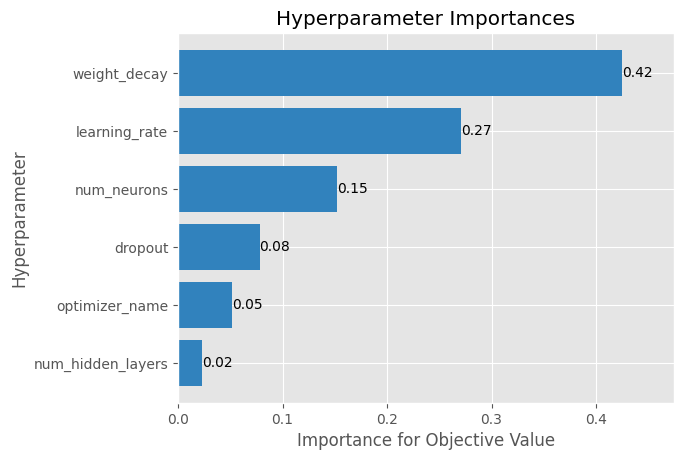

time: 306 ms (started: 2023-05-07 20:44:36 +00:00)


In [7]:
#shows the importance of each hyperparameter
fig = optuna.visualization.matplotlib.plot_param_importances(study)
fig

In [8]:
# Retrieve the best set of hyperparameters
best_params = study.best_params
print(best_params)

{'optimizer_name': 'AdamW', 'weight_decay': 0.0032752205072157027, 'learning_rate': 0.004963706950493226, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 256}
time: 1.53 ms (started: 2023-05-07 20:44:40 +00:00)


In [ ]:
import os
import shutil

# Set the random seed for reproducibility
torch.manual_seed(42)

#this code combines both train and validation dataset into one training set, so we can use this to train the model on a larger dataset. 
train_dir = '/data/train'
val_dir = '/data/valid'

# Loop through the subdirectories in val_dir and move their files to train_dir
for class_dir in os.listdir(val_dir):
    src_class_dir = os.path.join(val_dir, class_dir)
    dst_class_dir = os.path.join(train_dir, class_dir)
        
    # Create the destination directory if it doesn't exist yet
    if not os.path.exists(dst_class_dir):
        os.makedirs(dst_class_dir)
        
    # Loop through the files in the source directory and move them to the destination directory
    for file in os.listdir(src_class_dir):
        src_file = os.path.join(src_class_dir, file)
        dst_file = os.path.join(dst_class_dir, file)
        shutil.move(src_file, dst_file)

# Remove the val_dir if it is empty
if not os.listdir(val_dir):
    os.rmdir(val_dir)


In [8]:
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import Subset

# Set the random seed for reproducibility
torch.manual_seed(42)

# Load and transform the data
train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)

# load the data and shuffle the training data
train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True, num_workers=4)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True,num_workers=4)

time: 71.6 ms (started: 2023-05-08 14:14:43 +00:00)


In [9]:
import timm 
#look up all the maxvit models in timm's library
mvitv2_models = timm.list_models('*mvitv2*')
mvitv2_models

['mvitv2_base',
 'mvitv2_large',
 'mvitv2_small',
 'mvitv2_small_cls',
 'mvitv2_tiny']

time: 111 ms (started: 2023-05-08 14:14:44 +00:00)


In [ ]:
#create the mvitv2  model
#to create this code, timm's library has been used. 
#create model with new variable name and the best HP values to re-train the model 

import timm 
import torch
import torch.nn as nn

# Set the random seed for reproducibility
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
new_model = timm.create_model('mvitv2_large', pretrained=True, num_classes=8)

num_in_features = new_model.get_classifier().in_features

# Define the classification head with the best hyperparameter values
num_hidden_layers = 1
num_neurons = 256
dropout = 0.5
classifier_layers = []
for i in range(num_hidden_layers):
    if i == 0:
        in_features = num_in_features
        out_features = num_neurons
    else:
        in_features = num_neurons
        out_features = num_neurons
    classifier_layers.extend([
        nn.Linear(in_features, out_features),
        nn.BatchNorm1d(out_features),
        nn.Dropout(p=dropout),
    ])
classifier_layers.append(nn.Linear(num_neurons, 8))
new_model.head.fc = nn.Sequential(*classifier_layers)

#freeze the weights
for param in new_model.parameters():
    param.requires_grad = False
   
# unfreeze the last fc layer
for param in new_model.head.parameters():
    param.requires_grad = True


new_model.to(device)

In [11]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=new_model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MultiScaleVit (MultiScaleVit)                                [32, 3, 224, 224]    [32, 8]              --                   Partial
├─PatchEmbed (patch_embed)                                   [32, 3, 224, 224]    [32, 3136, 144]      --                   False
│    └─Conv2d (proj)                                         [32, 3, 224, 224]    [32, 144, 56, 56]    (21,312)             False
├─ModuleList (stages)                                        --                   --                   --                   False
│    └─MultiScaleVitStage (0)                                [32, 3136, 144]      [32, 3136, 288]      --                   False
│    │    └─ModuleList (blocks)                              --                   --                   (662,976)            False
│    └─MultiScaleVitStage (1)                                [32, 3136, 288]      [3

time: 2.59 s (started: 2023-05-08 14:14:50 +00:00)


In [12]:
# define optimizers and loss function and use the best hyperparameters found during the HP tuning
import torch.optim as optim

# Set the random seed for reproducibility
torch.manual_seed(42)

# define optimizers and loss function. 
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(new_model.parameters(), lr=0.004963706950493226, weight_decay = 0.0032752205072157027)

time: 3.25 ms (started: 2023-05-08 14:14:52 +00:00)


In [13]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

# Lists to store the loss and accuracy values
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Initialize variables for early stopping
best_test_loss = float('inf')
no_improvement_count = 0
epochs = 18
num_epochs = 18

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    running_total = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()    # Scale the gradients
            scaler.step(optimizer)           # Update the model parameters
            scaler.update()                  # Update the scaler

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        running_total += labels.size(0)
        running_corrects += (predicted == labels).sum().item()

    # Calculate the training loss and training accuracy
    train_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = 100 * running_corrects / running_total

    # evaluate on the test set
    new_model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    y_true = []
    y_scores = []
    y_pred = []
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = new_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item() * labels.size(0)

            # collect the predictions for the metrics calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    # Calculate the test accuracy and test loss
    test_accuracy = 100 * correct / total
    test_loss /= len(test_dataloader.dataset)
  
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")
            
    # Save the loss and accuracy values
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)

Epoch 1/18: Train Loss: 1.0631, Train Acc: 63.0979, Test Loss: 0.9100, Test Acc: 66.8841
Epoch 2/18: Train Loss: 0.8507, Train Acc: 69.2673, Test Loss: 0.8668, Test Acc: 68.7260
Epoch 3/18: Train Loss: 0.7977, Train Acc: 70.8999, Test Loss: 0.8882, Test Acc: 69.7237
Epoch 4/18: Train Loss: 0.7665, Train Acc: 72.0044, Test Loss: 0.8646, Test Acc: 69.0714
Epoch 5/18: Train Loss: 0.7483, Train Acc: 72.8977, Test Loss: 0.8214, Test Acc: 70.6830
Epoch 6/18: Train Loss: 0.7259, Train Acc: 73.4785, Test Loss: 0.8866, Test Acc: 70.0691
Epoch 7/18: Train Loss: 0.7114, Train Acc: 74.3278, Test Loss: 0.8205, Test Acc: 70.4528
Epoch 8/18: Train Loss: 0.7073, Train Acc: 74.1562, Test Loss: 0.8323, Test Acc: 70.4912
Epoch 9/18: Train Loss: 0.6955, Train Acc: 74.5787, Test Loss: 0.8123, Test Acc: 70.3761
Epoch 10/18: Train Loss: 0.6864, Train Acc: 74.9527, Test Loss: 0.8179, Test Acc: 70.2609
Epoch 11/18: Train Loss: 0.6688, Train Acc: 75.5072, Test Loss: 0.8316, Test Acc: 70.2993
Epoch 12/18: Train 

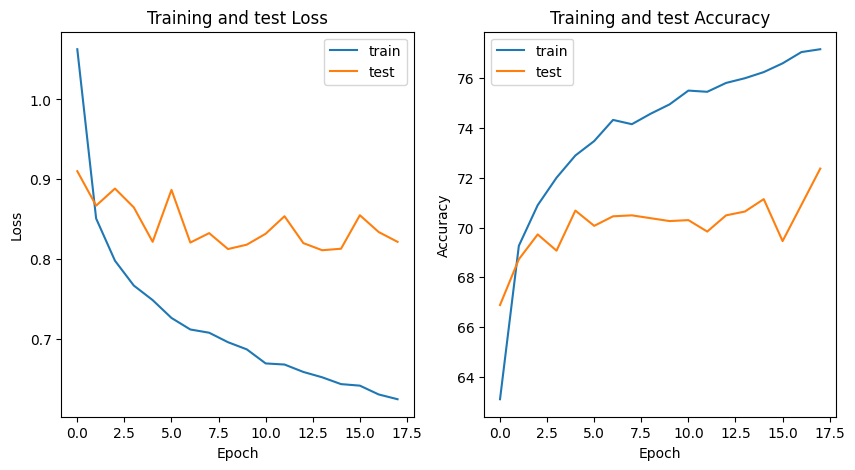

time: 244 ms (started: 2023-05-08 15:25:43 +00:00)


In [14]:
# Plot the validation and training loss and accuracy values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and test Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(test_accs, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy')
ax[1].legend()
plt.show()

In [15]:
#evaluate on test set and calculate metrics, we are calculating macro f1 and roc-auc score, because of the heavily imbalanced dataset
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
import pandas as pd
import numpy as np

new_model.eval()
test_loss = 0.0
test_acc = 0.0
y_true = []
y_scores = []
y_pred = []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
        outputs = new_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        test_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

        # Append predictions to lists
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

test_loss /= len(test_dataloader.dataset)
test_acc /= len(test_dataloader.dataset)

# Calculate metrics

import warnings
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(8)], digits=4)

conf_mat = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(np.array(pd.get_dummies(y_true)), y_scores, average='macro')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate other metrices
n_classes = conf_mat.shape[0]
sensitivity = 0
specificity = 0
for i in range(n_classes):
    tp = conf_mat[i,i]
    fn = np.sum(conf_mat[i,:]) - tp
    fp = np.sum(conf_mat[:,i]) - tp
    tn = np.sum(conf_mat) - tp - fn - fp
    sensitivity += tp / (tp + fn) * np.sum(conf_mat[i,:])
    specificity += tn / (tn + fp) * np.sum(conf_mat[i,:])
sensitivity /= np.sum(conf_mat)
specificity /= np.sum(conf_mat)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Loss: 0.8214
Test Accuracy: 0.7237
Sensitivity: 0.7237
Specificity: 0.8643
ROC-AUC: 0.9054
F1-score: 0.7113
Classification Report:
              precision    recall  f1-score   support

           0     0.5098    0.2921    0.3714        89
           1     0.5752    0.7749    0.6603       311
           2     0.5628    0.5036    0.5315       276
           3     0.8750    0.2593    0.4000        27
           4     0.6976    0.4511    0.5479       450
           5     0.8146    0.8992    0.8548      1349
           6     0.5294    0.5488    0.5389        82
           7     0.7500    0.5455    0.6316        22

    accuracy                         0.7237      2606
   macro avg     0.6643    0.5343    0.5671      2606
weighted avg     0.7199    0.7237    0.7113      2606

time: 27 s (started: 2023-05-08 15:25:43 +00:00)


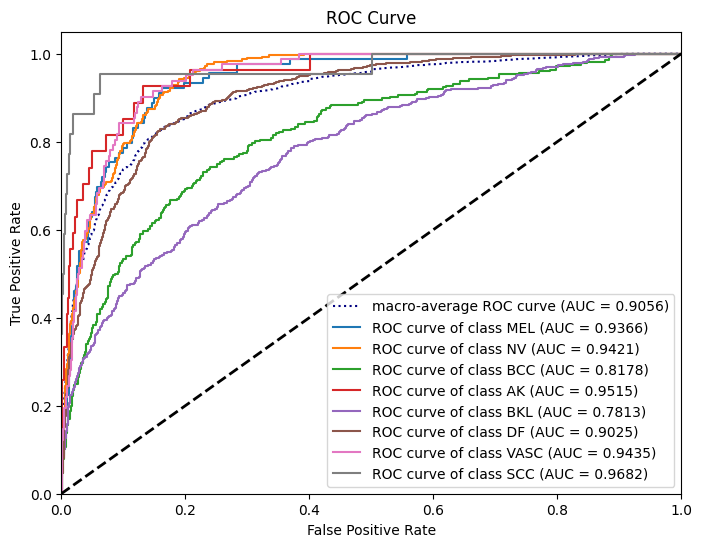

time: 174 ms (started: 2023-05-08 15:26:10 +00:00)


In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Convert the y_true and y_scores lists to arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_true))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (AUC = {0:0.4f})'.format(roc_auc["macro"]), color='navy', linestyle=':')

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.4f})'.format(class_dict[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

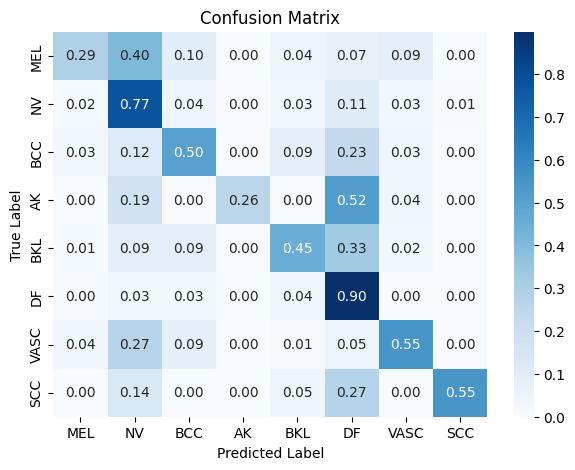

time: 360 ms (started: 2023-05-08 15:26:10 +00:00)


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
class_labels = sorted(list(class_dict.keys()), key=lambda x: int(x))
ax.xaxis.set_ticklabels([class_dict[label] for label in class_labels])
ax.yaxis.set_ticklabels([class_dict[label] for label in class_labels])
plt.show()

